In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
from torchvision import datasets
import multiprocessing

In [2]:
train_dir = './images/train'
test_dir = './images/validation'


In [3]:
from PIL import Image
image = Image.open('./images/train/happy/7.jpg')
width, height = image.size
print(f"Image size: {width}x{height}")
mode = image.mode
print(f"Image mode (channels): {mode}")


Image size: 48x48
Image mode (channels): L


In [4]:
from imblearn.over_sampling import SMOTE


# Define the transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((48, 48)),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Grayscale(num_output_channels=1)
])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.ImageFolder(root='images/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='images/validation', transform=transform)


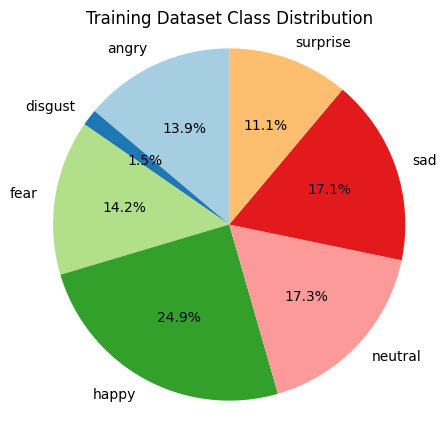

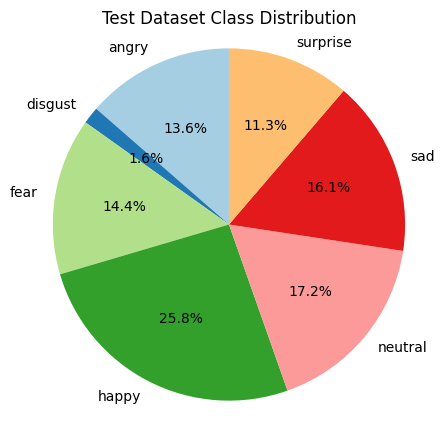

In [5]:

train_class_counts = [0] * len(train_dataset.classes)
test_class_counts = [0] * len(test_dataset.classes)

for _, label in train_dataset:
    train_class_counts[label] += 1


for _, label in test_dataset:
    test_class_counts[label] += 1

train_class_names = train_dataset.classes
test_class_names = test_dataset.classes

plt.figure(figsize=(5, 5))
plt.pie(train_class_counts, labels=train_class_names,autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Training Dataset Class Distribution')
plt.axis('equal')  
plt.show()


plt.figure(figsize=(5, 5))
plt.pie(test_class_counts, labels=test_class_names,autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Test Dataset Class Distribution')
plt.axis('equal')  
plt.show()



In [6]:
print(train_class_counts)
print(test_class_counts)


[3993, 436, 4103, 7164, 4982, 4938, 3205]
[960, 111, 1018, 1825, 1216, 1139, 797]


In [7]:

features = []
labels = []
for image, label in train_dataset:
    features.append(image.numpy().flatten())  
    labels.append(label)
    
features = np.array(features)
labels = np.array(labels)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(features, labels)

print(f"Original dataset size: {len(labels)}")
print(f"Resampled dataset size: {len(y_resampled)}")

X_resampled = torch.tensor(X_resampled).view(-1, 1, 48, 48)  
y_resampled = torch.tensor(y_resampled)

resampled_dataset = TensorDataset(X_resampled, y_resampled)
train_loader = DataLoader(resampled_dataset, batch_size=32, shuffle=True, num_workers=0)

test_size = int(0.5 * len(test_dataset))
val_size = len(test_dataset) - test_size

test_data, val_data = random_split(test_dataset, [test_size, val_size])


val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

print(f"Train Loader Size: {len(train_loader.dataset)}")
print(f"Validation Loader Size: {len(val_loader.dataset)}")
print(f"Test Loader Size: {len(test_loader.dataset)}")


Original dataset size: 28821
Resampled dataset size: 50148
Train Loader Size: 50148
Validation Loader Size: 3533
Test Loader Size: 3533


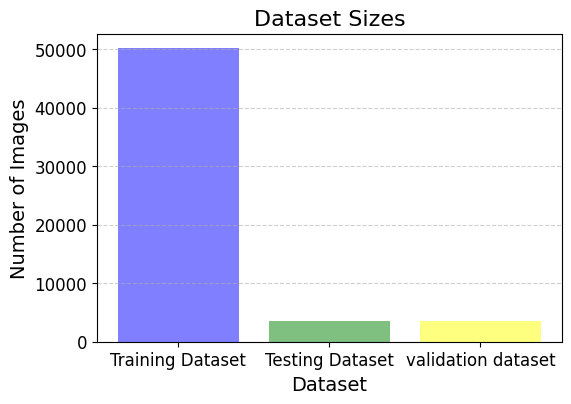

In [8]:
train_size=len(train_loader.dataset)
test_size=len(test_loader.dataset)
val_size=len(val_loader.dataset)
# Dataset labels and sizes
dataset_labels = ['Training Dataset', 'Testing Dataset','validation dataset']
dataset_sizes = [train_size, test_size,val_size]


plt.figure(figsize=(6, 4))
plt.bar(dataset_labels, dataset_sizes, color=['blue', 'green','yellow'], alpha=0.5)
plt.xlabel('Dataset', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.title('Dataset Sizes', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


In [9]:
for images, labels in train_loader:
    print(images.shape)  
    print(labels.shape)  
    break



torch.Size([32, 1, 48, 48])
torch.Size([32])


In [10]:
class CNN_Model3(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_Model3, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.1)
        
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)  
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.2)
        
       
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)  
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)  
        self.bn6 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(0.2)
        
        
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)  # padding=1 for "same"
        self.bn8 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout4 = nn.Dropout(0.2)
        
       
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 3 * 3, 64) 
        self.bn9 = nn.BatchNorm1d(64)
        self.dropout5 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(64, 64)
        self.bn10 = nn.BatchNorm1d(64)
        self.dropout6 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
       
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = self.dropout3(x)
        
        
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
       
        x = self.flatten(x)
        x = F.relu(self.bn9(self.fc1(x)))
        x = self.dropout5(x)
        
        x = F.relu(self.bn10(self.fc2(x)))
        x = self.dropout6(x)
        
        x = self.fc3(x)
        return F.softmax(x, dim=1)

# Create the model
model = CNN_Model3(num_classes=7)


In [11]:
device = torch.device("cpu")

# training and testing Function
def train_and_evaluate(model, epochs=10):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    
    train_accuracies, val_accuracies = [], []
    #training
    for epoch in range(epochs):
        print(f" Training epoch {epoch}")
        model.train()
        train_correct, train_total = 0, 0
        train_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_loss += loss.item()
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_accuracies.append(train_accuracy)
         # testing
        model.eval()
        val_loss=0
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = val_correct / val_total
        val_loss /= len(val_loader)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy:{val_accuracy:.4f} ")

    return train_accuracies,val_accuracies



In [12]:
train_acc, val_acc = train_and_evaluate(CNN_Model3(),epochs=25)


 Training epoch 0
Epoch [1/25], Train Accuracy: 0.3784, Test Accuracy:0.4489 
 Training epoch 1
Epoch [2/25], Train Accuracy: 0.4771, Test Accuracy:0.4851 
 Training epoch 2
Epoch [3/25], Train Accuracy: 0.5143, Test Accuracy:0.5123 
 Training epoch 3
Epoch [4/25], Train Accuracy: 0.5420, Test Accuracy:0.5330 
 Training epoch 4
Epoch [5/25], Train Accuracy: 0.5631, Test Accuracy:0.5310 
 Training epoch 5
Epoch [6/25], Train Accuracy: 0.5803, Test Accuracy:0.5454 
 Training epoch 6
Epoch [7/25], Train Accuracy: 0.5960, Test Accuracy:0.5633 
 Training epoch 7
Epoch [8/25], Train Accuracy: 0.6072, Test Accuracy:0.5590 
 Training epoch 8
Epoch [9/25], Train Accuracy: 0.6226, Test Accuracy:0.5616 
 Training epoch 9
Epoch [10/25], Train Accuracy: 0.6330, Test Accuracy:0.5627 
 Training epoch 10
Epoch [11/25], Train Accuracy: 0.6449, Test Accuracy:0.5740 
 Training epoch 11
Epoch [12/25], Train Accuracy: 0.6524, Test Accuracy:0.5610 
 Training epoch 12
Epoch [13/25], Train Accuracy: 0.6660, T

In [13]:
model3=CNN_Model3()
torch.save(model3.state_dict(),"model3_state.pth")

In [14]:
from torchsummary import summary
model = CNN_Model3()
summary(model, input_size=(1, 48, 48), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 32, 48, 48]             320
       BatchNorm2d-2           [32, 32, 48, 48]              64
            Conv2d-3           [32, 32, 48, 48]           9,248
       BatchNorm2d-4           [32, 32, 48, 48]              64
         MaxPool2d-5           [32, 32, 24, 24]               0
           Dropout-6           [32, 32, 24, 24]               0
            Conv2d-7           [32, 64, 24, 24]          18,496
       BatchNorm2d-8           [32, 64, 24, 24]             128
            Conv2d-9           [32, 64, 24, 24]          36,928
      BatchNorm2d-10           [32, 64, 24, 24]             128
        MaxPool2d-11           [32, 64, 12, 12]               0
          Dropout-12           [32, 64, 12, 12]               0
           Conv2d-13          [32, 128, 12, 12]          73,856
      BatchNorm2d-14          [32, 128,

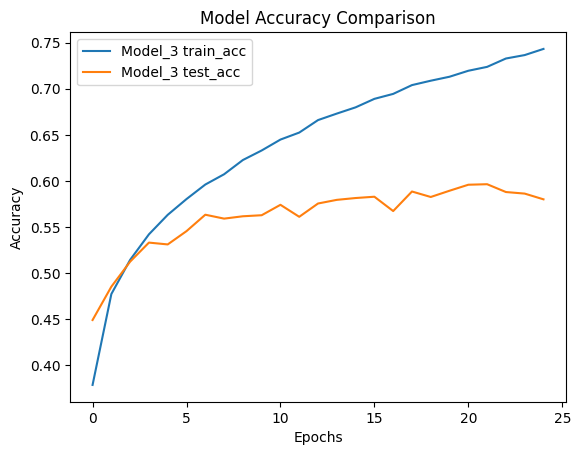

In [15]:
plt.plot(train_acc, label= "Model_3 train_acc")
plt.plot(val_acc,label= "Model_3 test_acc")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend(fontsize=10, loc='upper left')
plt.show()

In [16]:
model = CNN_Model3() 
model.eval()  
test_loss = 0.0
correct = 0
total = 0
criterion=nn.CrossEntropyLoss()
with torch.no_grad():  
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  

        
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 1.9417, Test Accuracy: 26.24%


In [18]:
import tkinter as tk
from tkinter import filedialog, messagebox

model=CNN_Model3()
model.load_state_dict(torch.load('model3_state.pth'))

model.eval()

#  emotion classes 
emotion_classes = ['angry', 'disgust', 'fear', 'happy','neutral','sad', 'surprise']

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), 
    transforms.Resize((48, 48)),                
    transforms.ToTensor(),                       
    ])

def predict_emotion(img_path):
    img = Image.open(img_path)
    img_transformed = transform(img).unsqueeze(0)  
    with torch.no_grad():
        outputs = model(img_transformed)
        _, predicted = torch.max(outputs, 1)
        predicted_class = emotion_classes[predicted.item()]
    return predicted_class
    
def upload_and_predict():
    img_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if img_path:
        predicted_class = predict_emotion(img_path)
        result_label.config(text=f"Predicted Emotion: {predicted_class}")
    else:
        messagebox.showerror("Error", "No image selected!")


root = tk.Tk()
root.title("Emotion Detection")
root.geometry("500x500")


upload_button = tk.Button(root, text="Upload Image", command=upload_and_predict, font=('Arial', 14))
upload_button.pack(pady=50)


result_label = tk.Label(root, text="Predicted Emotion: ", font=('Arial', 16))
result_label.pack(pady=20)


root.mainloop()


C:\Users\gaura\AppData\Local\Temp\ipykernel_9624\1204255247.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model3_state.pth'))
